# Projet numérique de Science des Données 2025

__Binôme numéro 51 -- SAGOT Gabin et BARRÉ Arthur__

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

## Librairies usuelles

In [24]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing, model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import BAuracy_score

import seaborn as sns

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [2]:
df_train = pd.read_csv('data/donnees_entrainement.csv')

In [3]:
df_train

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,21.0,85.0,55.0,7.0,36.2,84.0,1
1,36.0,145.0,100.0,6.9,39.5,73.0,2
2,15.5,120.0,75.0,7.4,39.0,74.0,0
3,49.0,135.0,100.0,15.9,37.8,72.0,1
4,56.5,120.0,90.0,12.0,36.9,74.0,1
...,...,...,...,...,...,...,...
795,27.5,90.0,55.0,7.5,37.1,89.0,0
796,32.0,115.0,90.0,7.6,36.2,71.0,0
797,53.5,100.0,70.0,7.7,36.2,68.0,0
798,18.5,120.0,70.0,7.5,37.1,69.0,0


Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [4]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')

# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

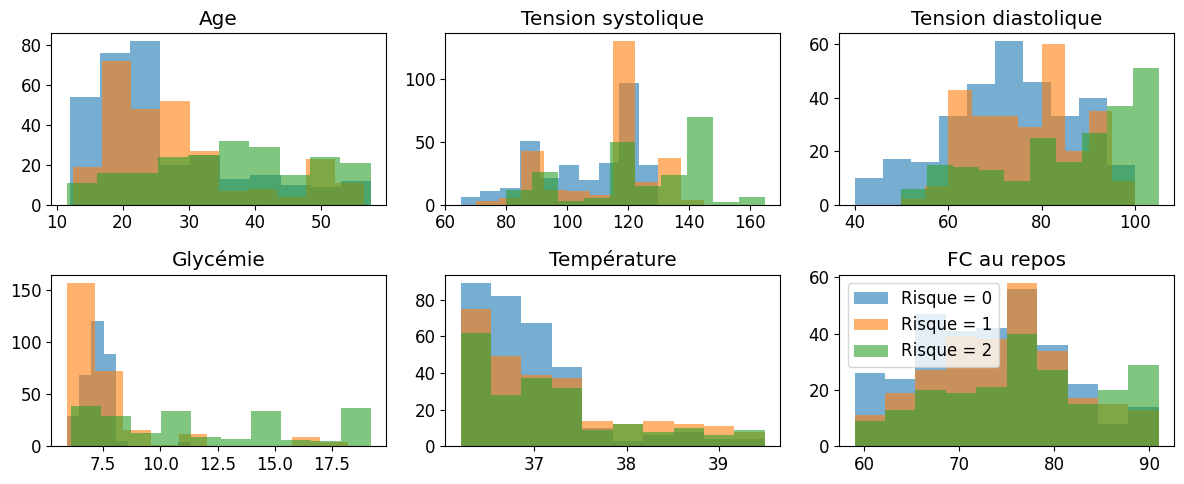

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(12,5))
axes = axes.flatten()

for (feat_idx, feat_name) in enumerate(df_train.columns[:-1]):
    ax = axes[feat_idx]
    for i in range(3):
        ax.hist(df_train[df_train.Risque==i][feat_name], bins = 10, alpha=0.6, label="Risque = "+str(i))
    ax.set_title(feat_name)
plt.legend()
plt.tight_layout()
plt.show()

### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

**Réponse** 


On constate que les valeurs prises par les différentes variables sont dans des ordres de grandeur cohérents, avec par exemple un âge compris entre 15 et 60 ans, des tensions systoliques comprises entre 70 et 160 mmHg (elles sont considérées normales autour de 130 mmHg), ou encore des fréquences cardiaques comprises en 60 et 90bpm.
Toutefois, il est déjà possible de relever certaines observations concernant les personnes de haut risque. De façon générale, celles-ci :
- sont plus âgées que les autres
- ont des tensions plus élevées que les autres
- ont des glycémies prenant des valeurs plus élevées que les autres

Pour l'instant, ces observations restent purement qualitatives.

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

**Réponse :**

On a un nombre de variables qui est encore assez faible (6), certains jeux de données pouvant parfois contenir des centaines de variables. Des tendances générales peuvent encore être décelées ici. Toutefois, une réduction de dimensions peut s'avérer pertinente pour simplifier encore plus le problème.

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

**Réponse**

On va représenter les données sous forme d'un nuage de points, ayant pour axes les deux composantes principales de `X_train`. Par ailleurs, on va colorer chaque point en fonction du risque qui lui est associé, pour voir si la nouvelle représentation permet de prédire le risque plus efficacement.
Les fourchettes de valeur prises par les variables sont différentes, leurs unités aussi. Pour mieux les comparer il est souhaitable de les standardiser.

In [6]:
def PCA_plot(X_train, scale=True):

    if scale:
        std_scale = preprocessing.StandardScaler().fit(X_train)
        X_scaled = std_scale.transform(X_train)
        X = X_scaled
    else:
        X = X_train

    pca = decomposition.PCA(n_components=2)
    pca.fit(X)
    X_projected = pca.transform(X)

    plt.figure(figsize =(5,5))
    plt.scatter(X_projected[:, 0], X_projected[:, 1], c=df_train["Risque"])
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")


    plt.colorbar(label='Risque')
    plt.plot()

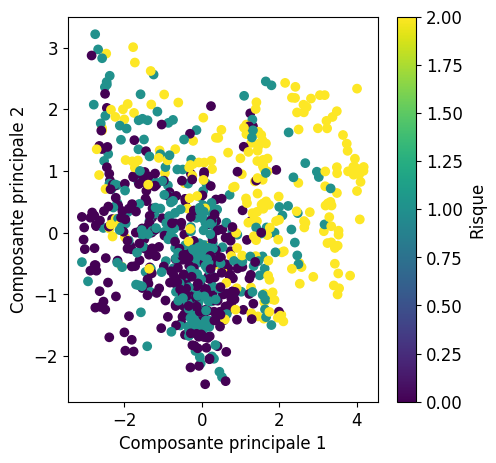

In [7]:
PCA_plot(X_train)

### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

**Réponse**

Même si on observe une plus grosse concentration de points associés à un risque élevée pour des valeurs élevées de la composante principale 1, il n'est en dehors de ça pas possible de trancher. Outre celle-ci, toutes les zones sont "homogènes" en risque. Cela implique que ces deux composantes principales ne sont pas utiles pour prédire le risque de grossesse difficile.

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

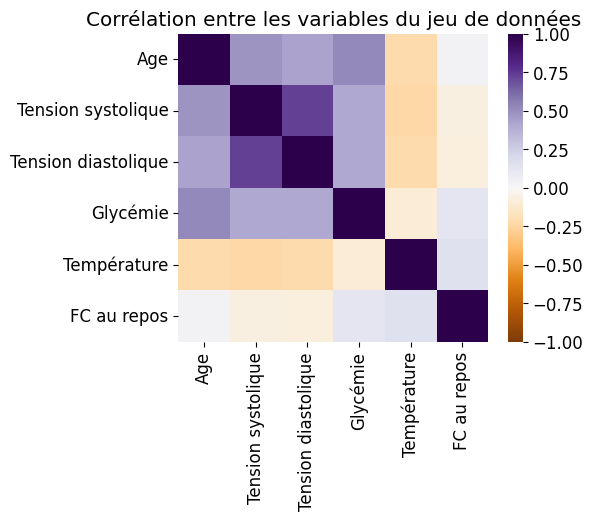

In [8]:
corr_matrix = df_train.drop(columns=['Risque']).corr()
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, center = 0, cmap='PuOr')
plt.title("Corrélation entre les variables du jeu de données");

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

**Réponse**

On constate que les tensions systoliques et diastoliques présentent une forte corrélation. Cela signifie qu'elles sont presques linéaires l'une de l'autre. Ainsi, la connaissance de l'une donne une bonne approximation de l'autre, assez pour n'en regarder qu'une des deux. On peut donc en retirer une afin de diminuer la dimension des données - par exemple la tension diastolique qui varie dans un domaine plus réduit, ce qui limite la précision sur ses mesures. 

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [9]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

In [10]:
# On compte le nombre de femme à risque sur le nombre de femme
nb_risque = np.sum(y_train_risk_vs_norisk) #484 donc majoritaire
nb_tot = np.size(y_train_risk_vs_norisk)   #800

# On prédirait que toute les femmes sont à risque donc on aurait
accuracy = nb_risque / nb_tot
print(f"l'accuracy est de {accuracy*100}% pour la méthode la plus triviale")

l'accuracy est de 60.5% pour la méthode la plus triviale


### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

**Réponse**

Ici ce critère compris entre 0 et 1 est plus pertinent car il est composé du taux de vrai positifs et du taux de vrai négatifs (rappel sur les 2 classes) ce qui permet d'avoir une image fidèle de la performence de notre classifieur

Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.BAuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.BAuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

**Réponse**

La phase d'entrainement est simplement la mise en mémoire de chaque point afin de déterminer par la suite quel point est le plus proche de celui qu'on cherche à classifier, pour lui attribuer la même classe (on suppose que toutes les données sont réduites centrées)

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

**Réponse**

Si l'on effectue un test avec le jeu d'entraînement, on aura forcément une précision équilibrée de 1 car chaque point du jeu d'entrainement est son plus proche voisin eet donc sera assigné à la bonne classe

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [21]:
# réduction et centrage de chaque colonne du df
facteurs_modif = df_train.columns.drop('Risque')
moy = df_train[facteurs_modif].mean()
ecart = df_train[facteurs_modif].std()
df_norm = (df_train[facteurs_modif] - moy) / ecart
df_norm['Risque'] = df_train['Risque'].values

X = df_norm.drop(columns=['Risque']) #le données dont on dispose
Y = df_norm['Risque'] #ce que l'on cherche à prédire

classificateur_1voisin = KNeighborsClassifier(n_neighbors=1)
classificateur_1voisin.fit(X, Y)

Y_pred = classificateur_1voisin.predict(X) #prédiction avec les mêmes données
score = BAuracy_score(Y, Y_pred) #calcul du score (BA)

print(f"Précision équilibrée sur le jeu d'entraînement : {score:.2f}")

Précision équilibrée sur le jeu d'entraînement : 1.00


### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

**Réponse**

Pour cet algorithme, l'utilisation de données centrées-réduites est nécessaire pour avoir un résultat pertinent. En effet comme il se base sur la notion de distance entre 2 données différentes. Il faut donc par exemple pouvoir comparer Age et Temperature. 

Il faut donc utiliser des données centrées-réduites.

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

Le meilleur k est : 9
BA sur les données d'entraînement : 0.712


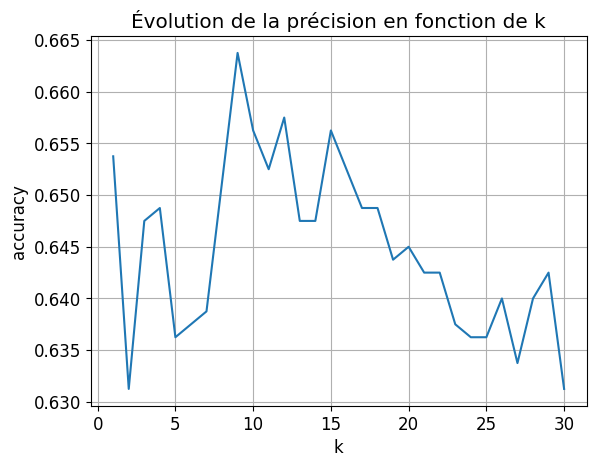

In [40]:
dico_k = {'n_neighbors': list(range(1,31))} #on teste pour k de 1 à 30
#La grille est donc composées de faible et grandes valeurs de k 

kpp = KNeighborsClassifier() #Classificateur K plus proche
grille = model_selection.GridSearchCV(kpp, dico_k, cv=10)  
grille.fit(X, Y) #entrainement de la grille

meilleur_k = grille.best_params_['n_neighbors']
meilleur_modele = grille.best_estimator_

Y_pred = meilleur_modele.predict(X)
BA = balanced_accuracy_score(Y, Y_pred)

print(f"Le meilleur k est : {meilleur_k}")
print(f"BA sur les données d'entraînement : {BA:.3f}")

mean_scores = grille.cv_results_['mean_test_score']
k_values = dico_k['n_neighbors']

plt.figure()
plt.plot(k_values, mean_scores)
plt.title("Évolution de la précision en fonction de k")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.grid()
plt.show()

**Réponse**

On remarque que la précision varie selon la valeur de k avec des valeurs plus faible quand k est très grand (k > 15) ou très faible (k < 8) à l'exception de 1 qui souffre de l'overfitting. Ainsi les valeurs souhaitables de k sont entre 8 et 15 avec l'optimale à 9.

## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.